# ELEC-E5510 — Exercise 1: 
## Feature extraction and Modeling the feature distribution

The goal of this exercise is to get familiar with the feature extraction process used in automatic speech recognition and to learn about the models we typically use to model the feature distributions. 

This notebook first runs through the practical computational steps for producing MFCC features. The code blocks are runnable and you may want to create new code blocks to run your own code. See e.g. [this](https://wiki.python.org/moin/BeginnersGuide/Programmers) if you wish to learn Python, and [this](https://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) for help with Notebooks. 

The notebook also includes the questions to be answered in your submission. Submit your answers in a separate PDF document; don't submit the notebook itself.

First we'll need to import some libraries

In [1]:
import numpy as np
import scipy.signal as signal
from scipy.signal import lfilter
import matplotlib.pyplot as plt

Next, we load the data that we are going to use

In [2]:
sampleword = np.load('sampleword.npy')
M = np.load('M.npy')
D = np.load('D.npy')

## MFCC feature extraction step by step

More information about each step of MFCC: [Mel Frequency Cepstral Coefficient (MFCC) tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

Let's start the exercise by extracting the so-called MFCC features of a sample word. Variable 'sampleword' contains a waveform of a Finnish word 'pyörremyrskyistä' sampled at the rate of 16000Hz. You can plot it by:

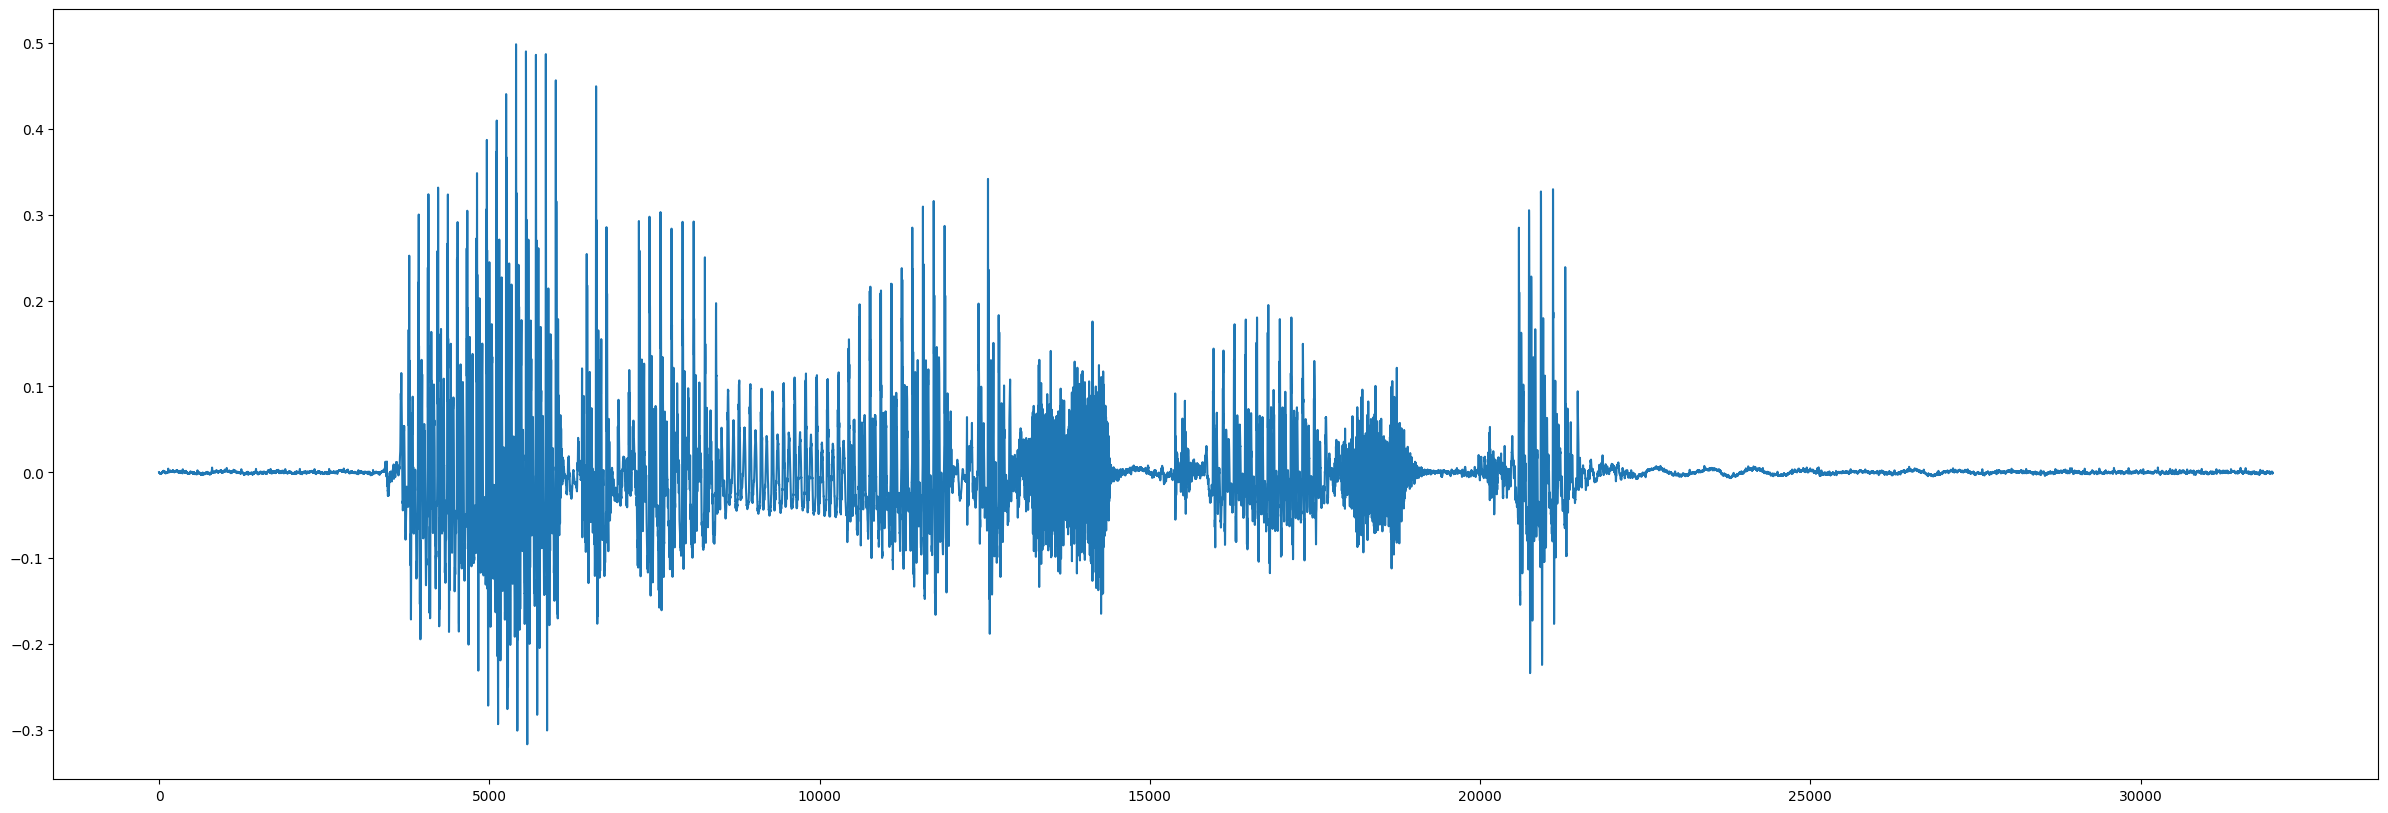

In [3]:
plt.rcParams["figure.figsize"] = (30, 10)
plt.plot(sampleword)

The first step of the feature extraction is the computation of the short-time Fourier spectrum. With Python:

In [4]:
# a helper function for plotting the spectrograms
def plot_spectrogram(spec):
    pho_times = [20, 26, 34, 43, 50, 59, 70, 77, 85, 94, 102, 109, 115, 123, 131]
    pho_labels=['p','y','ö','rr','e','m','y','r','s','k','y','i','s','t','ä']
    plt.xticks(pho_times, pho_labels)
    plt.ylim(0, spec.shape[0])
    plt.tick_params(labelsize=20)
    plt.imshow(spec, cmap='terrain')

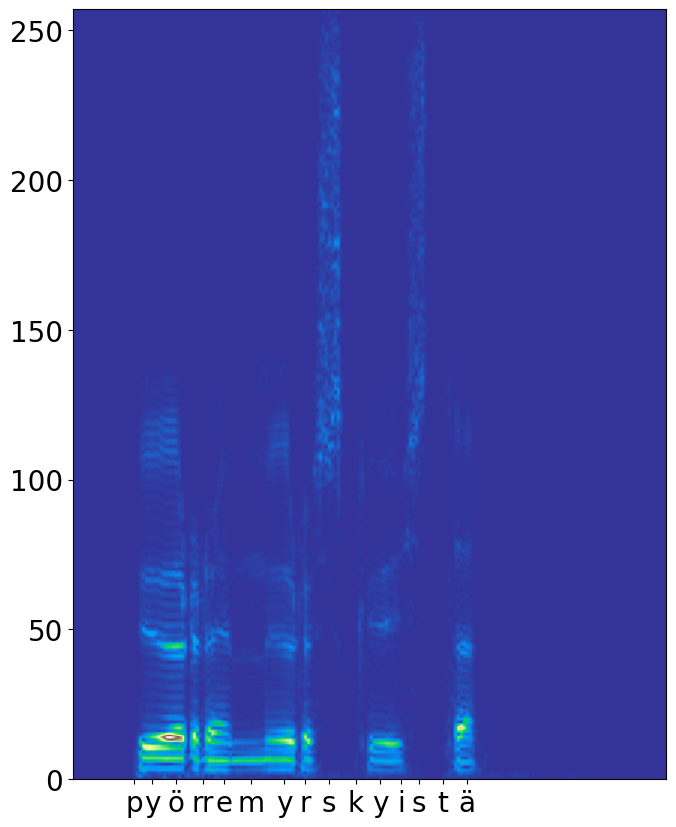

In [5]:
window_size = 400
nfft = 513
noverlap = 240

f, t, s = signal.spectrogram(sampleword, window=signal.hamming(window_size), noverlap=noverlap, nfft=nfft)
s = np.sqrt(np.abs(s))
plot_spectrogram(s)

This extracts the short-time Fourier spectrum of the sample word, using 25ms Hamming window, and displays it.

It is advisable to apply a high-pass filter to the waveform before taking the spectrum. You can compare the results with and without the filter:

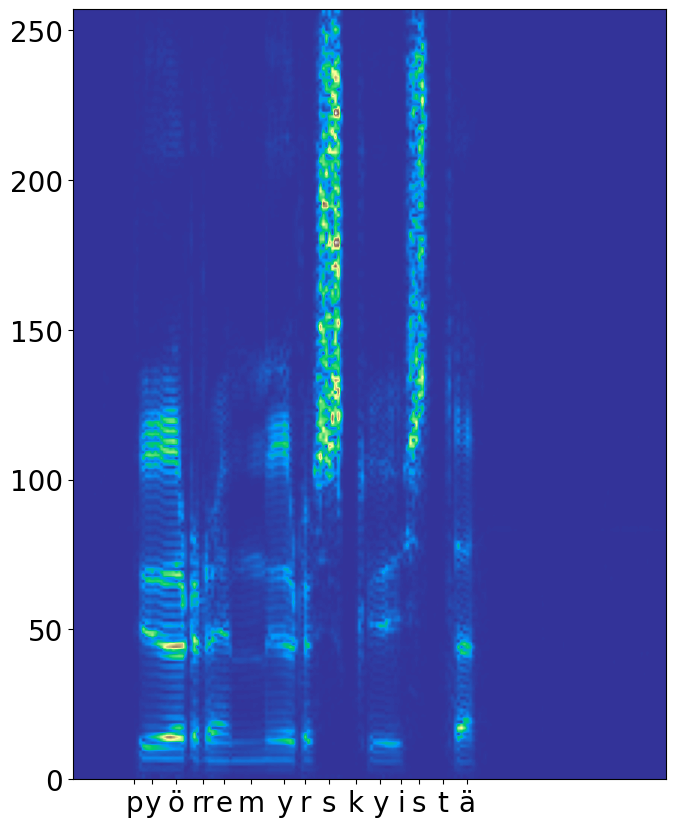

In [6]:
window_size = 400
nfft = 513
noverlap = 240

f, t, s2 = signal.spectrogram(lfilter([1, -0.97], 1, sampleword), window=signal.hamming(window_size), noverlap=noverlap, nfft=nfft)
s2 = np.sqrt(np.abs(s2))

plot_spectrogram(s2)

Continue with the filtered version of the spectrum. The next phase is to apply a non-linear frequency transformation. The variable M contains a matrix that applied to the spectrum computes the so-called mel-spectrum. You can visualize the triangular filters in M:

(0.0, 0.321468)

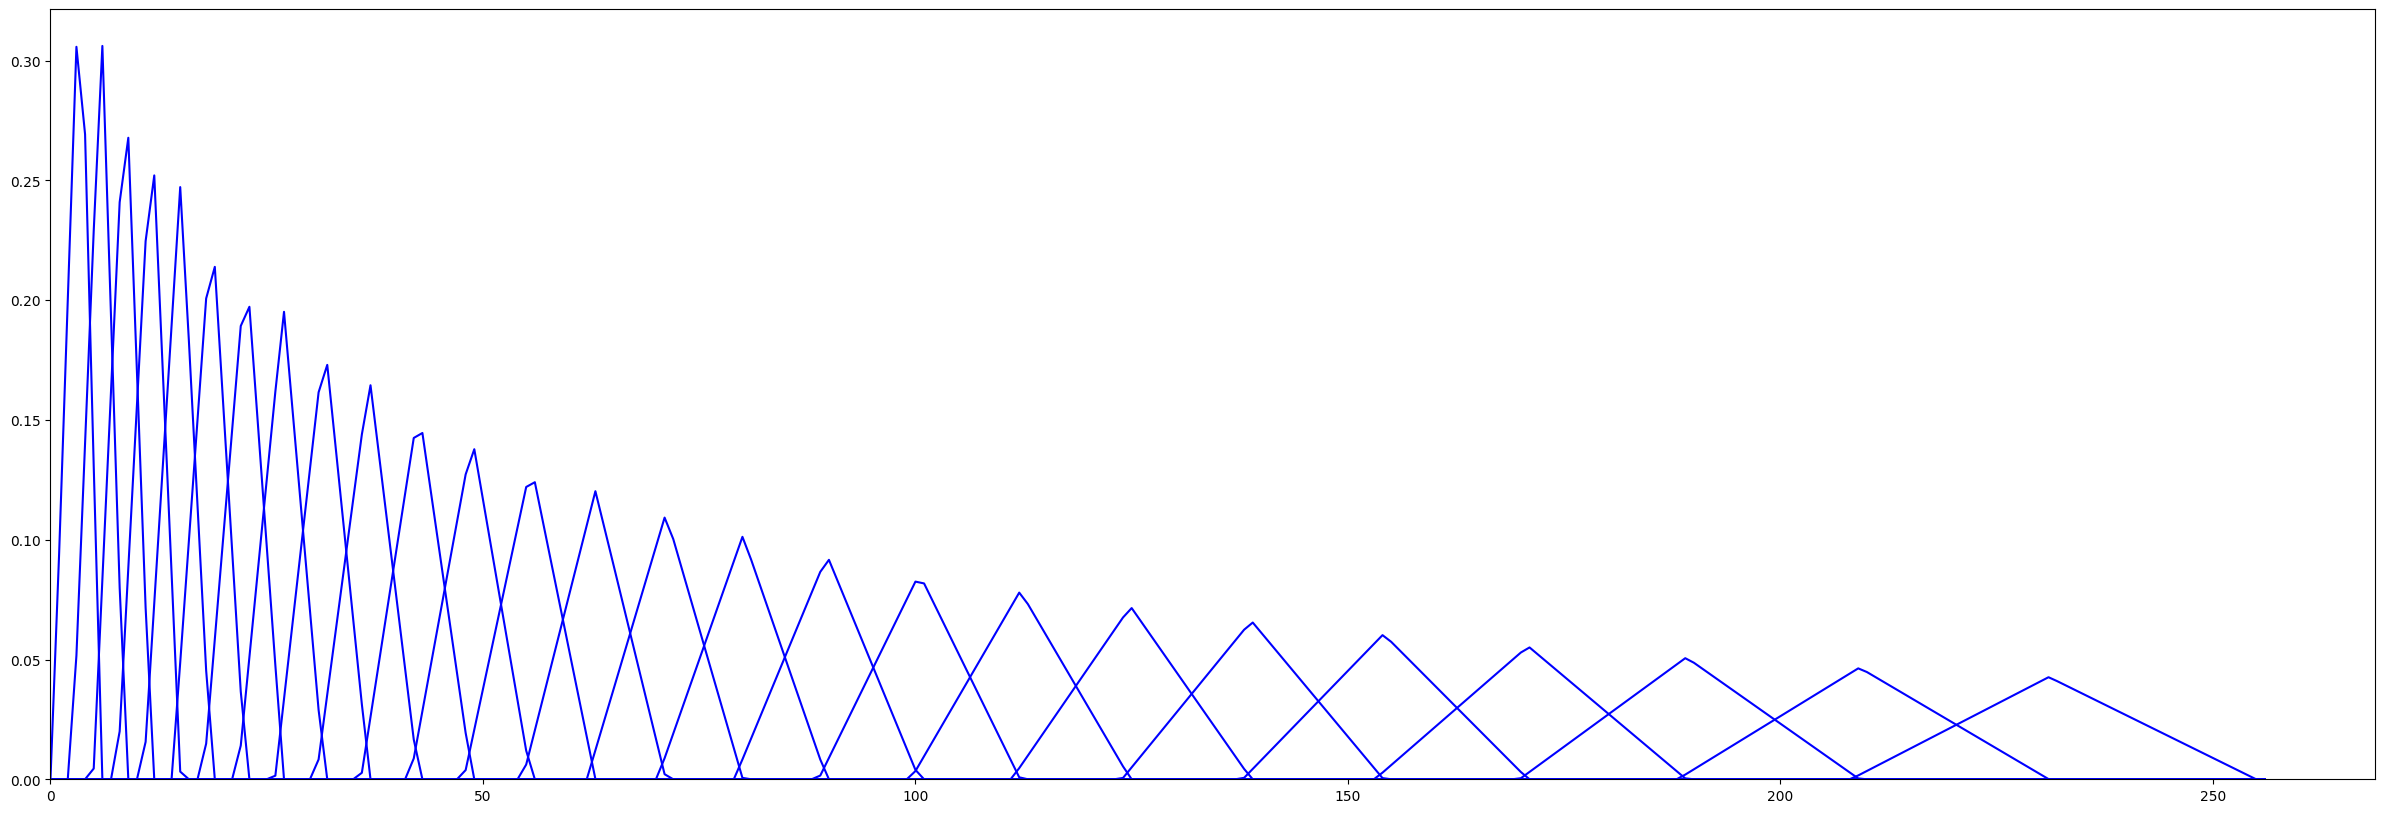

In [7]:
plt.plot(M.T, color='blue')
plt.xlim(xmin=0)
plt.ylim(ymin=0)

After the mel-transformation a logarithm is taken of the frequency bin energies to compress the energy values. Visualize the resulting logarithmic mel-spectrum:

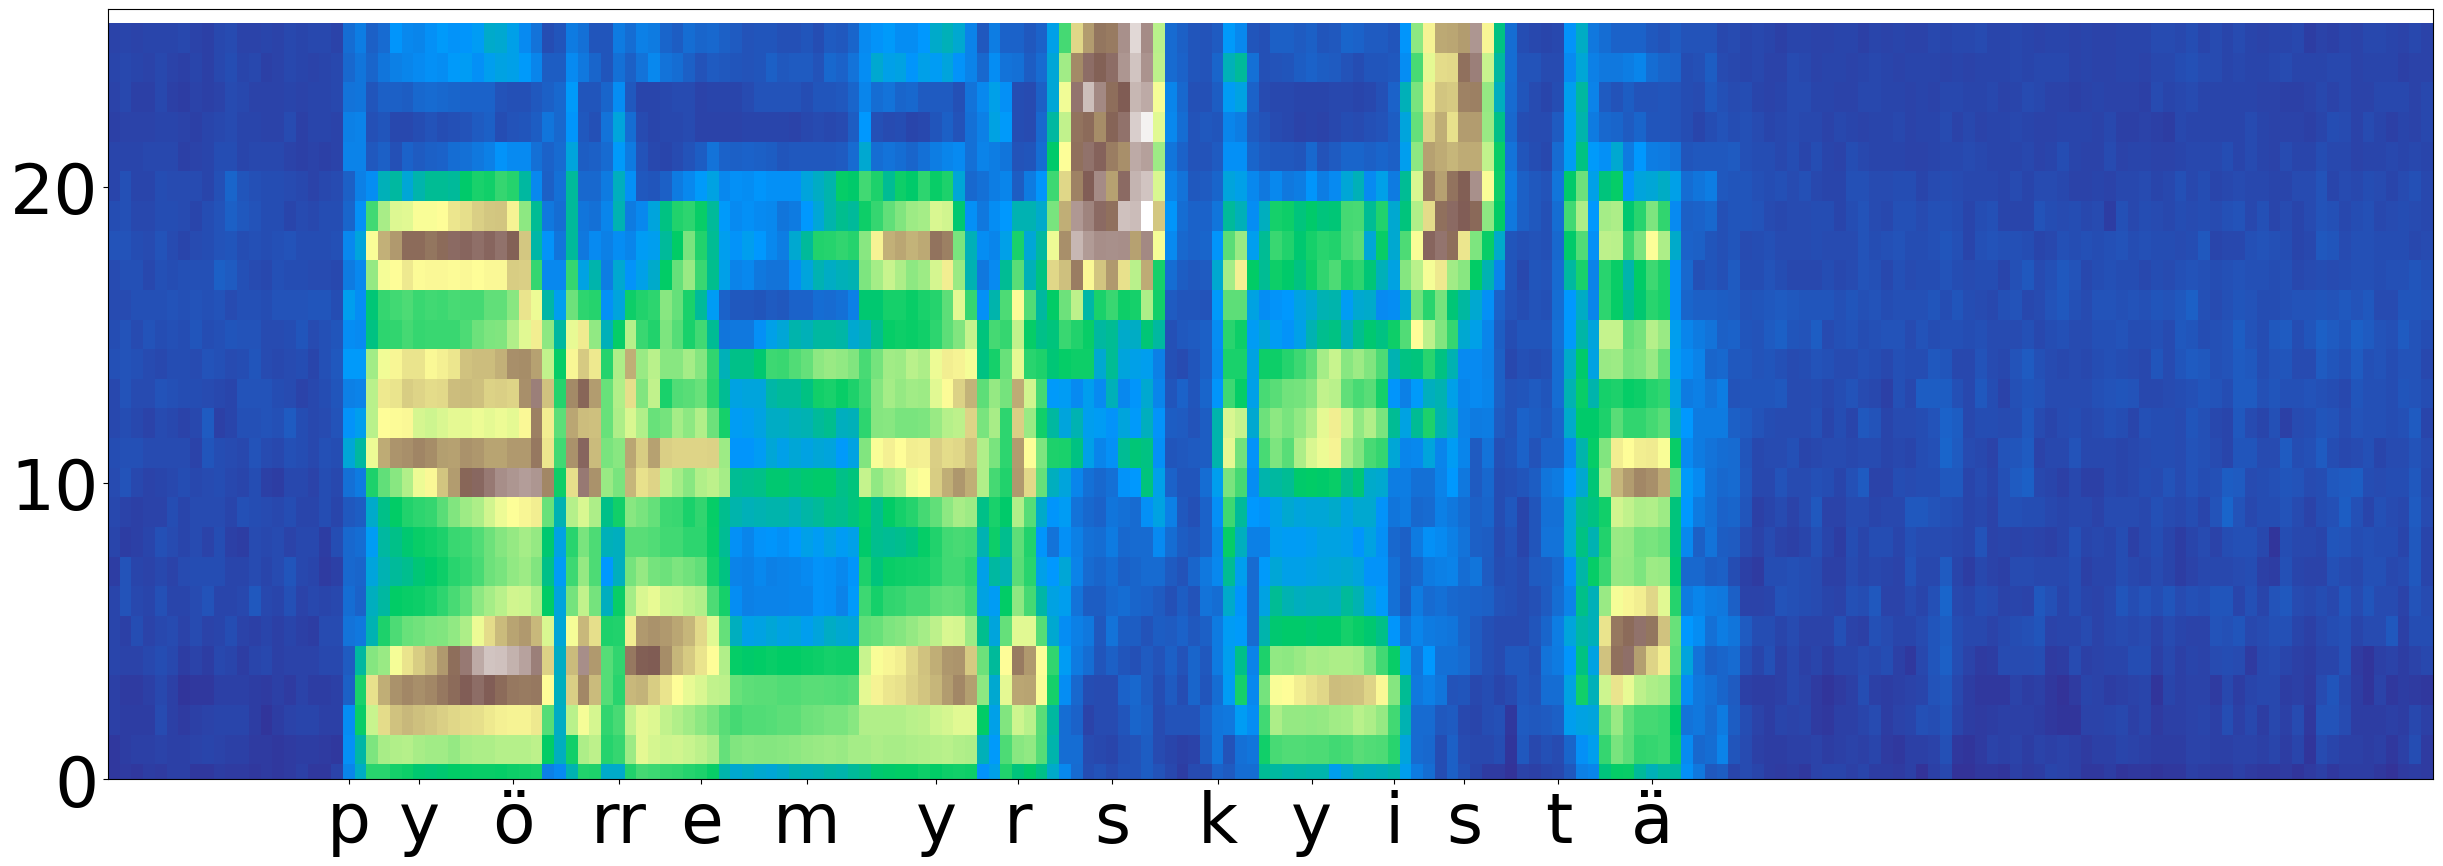

In [8]:
pho_times = [20, 26, 34, 43, 50, 59, 70, 77, 85, 94, 102, 109, 115, 123, 131]
pho_labels=['p','y','ö','rr','e','m','y','r','s','k','y','i','s','t','ä']
plt.xticks(pho_times, pho_labels)
plt.ylim(0, M.shape[0])
plt.tick_params(labelsize=50)
plt.imshow(np.log(M.dot(np.sqrt(np.abs(s2))) + 1), aspect='auto', cmap='terrain')

The last phase is to decorrelate the features and reduce the dimension. This is done using the discrete cosine transformation (DCT). A variable D contains the required matrix, you can again visualize it as with matrix M or plotting the matrix with:

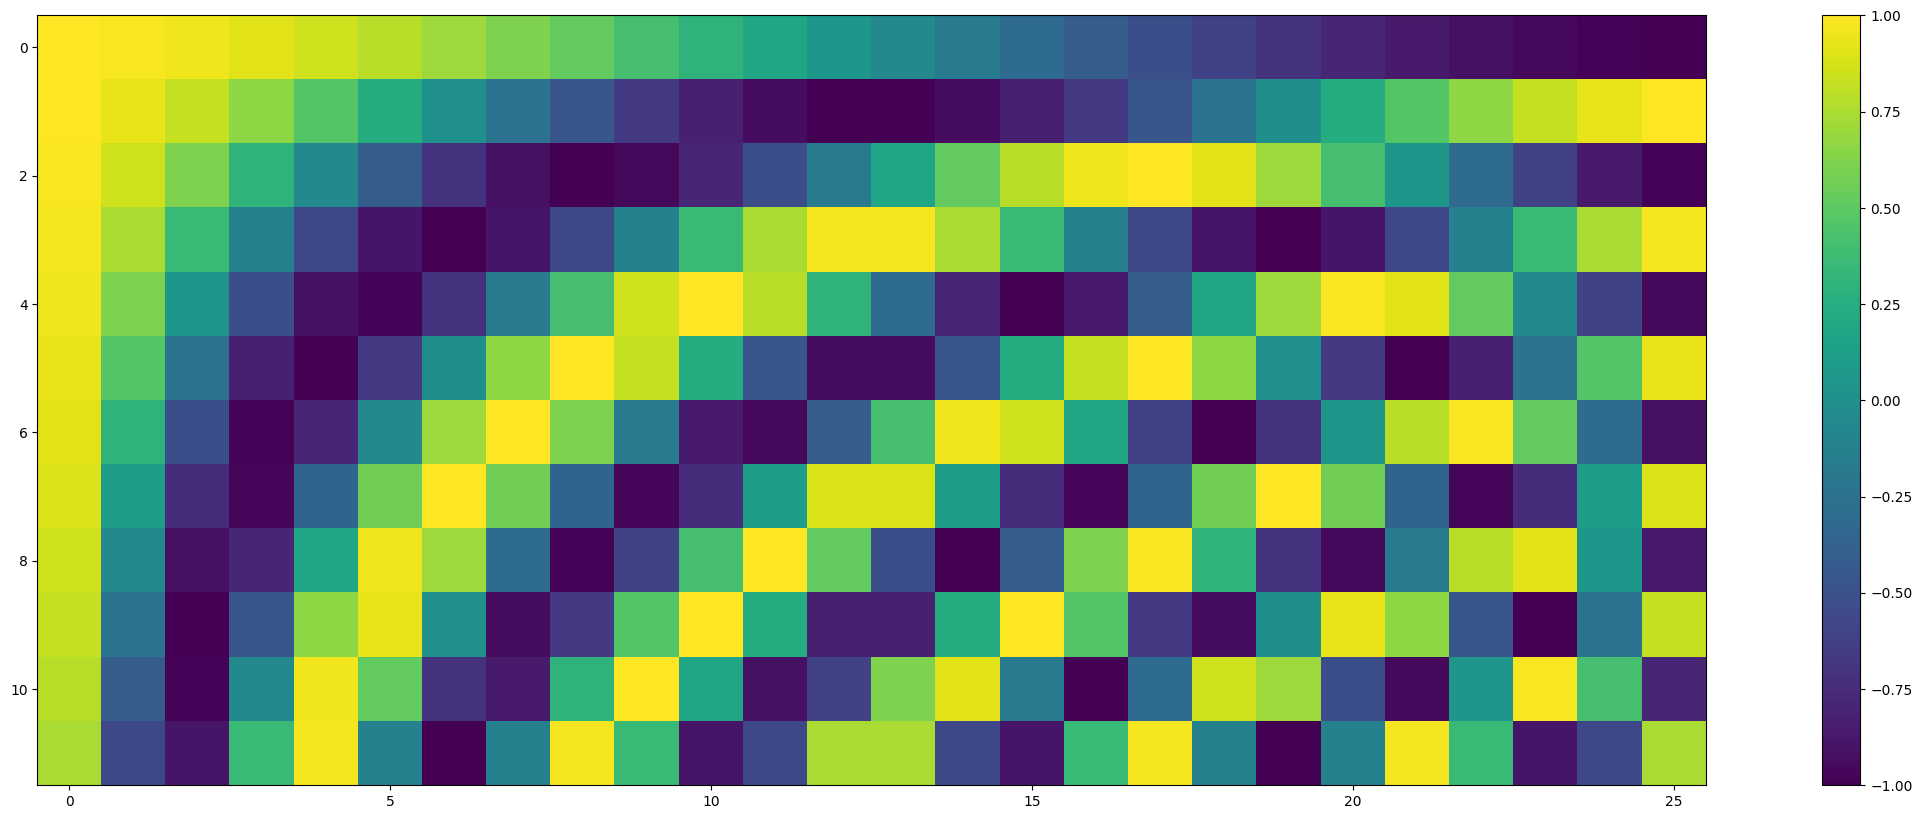

In [9]:
plt.imshow(D)
plt.colorbar()

The final features are obtained simply by:

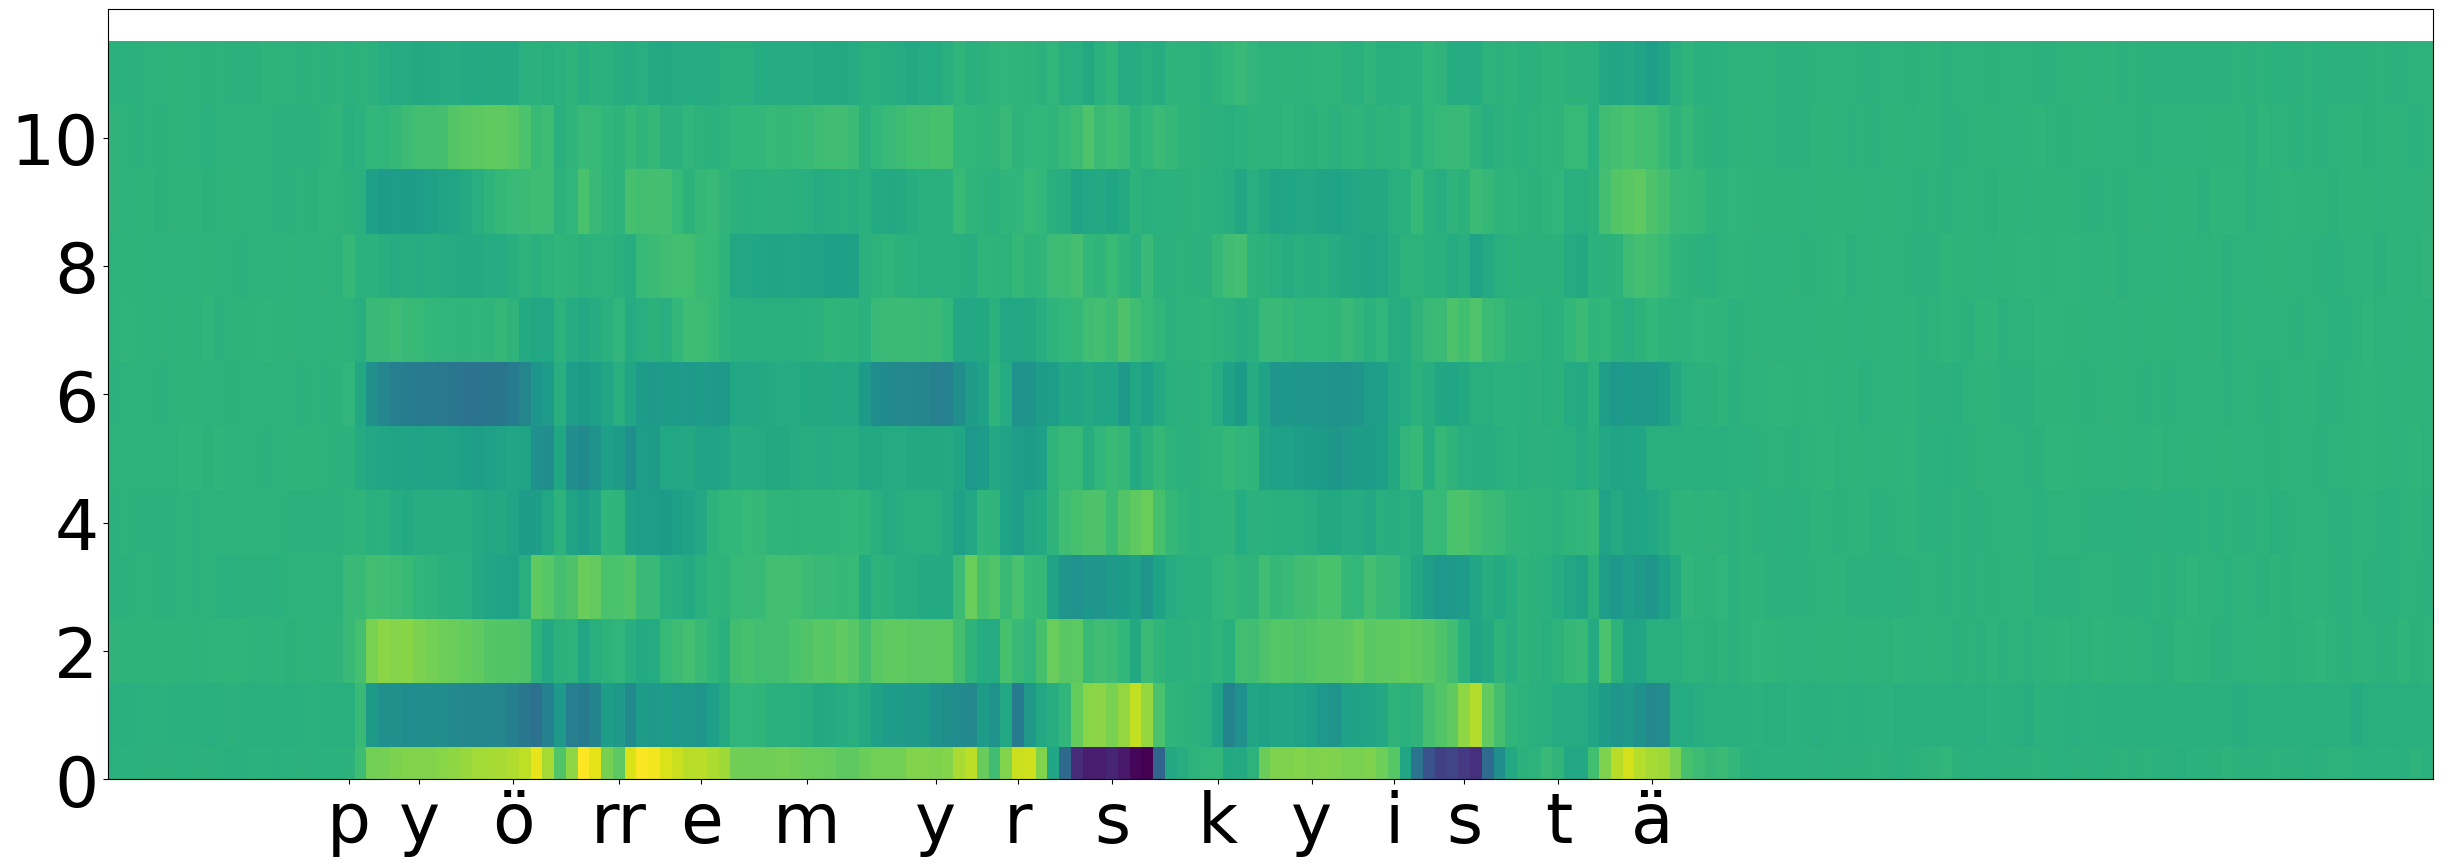

In [10]:
pho_times = [20, 26, 34, 43, 50, 59, 70, 77, 85, 94, 102, 109, 115, 123, 131]
pho_labels=['p','y','ö','rr','e','m','y','r','s','k','y','i','s','t','ä']
plt.xticks(pho_times, pho_labels)
plt.ylim(0, D.shape[0])
plt.yticks(np.arange(0, 12, step=2))
plt.tick_params(labelsize=50)
plt.imshow(D.dot(np.log(M.dot(np.sqrt(np.abs(s2))) + 1)), aspect='auto')

The final features are called Mel-frequency cepstral coefficients or MFCCs.

### Question 1:

a. What are the properties of MFCC features that make them well suited for automatic speech recognition?

b. Why wouldn't spectrogram or mel-spectrum features work so well?

## Gaussian mixture models

Gaussian mixture models (GMMs) are a very common feature distribution model in speech recognition. GMMs are flexible, general-purpose models. One of the big advantages of GMMs is having an effective estimation algorithm. Most often GMMs are estimated using the Expectation-Maximization (EM) algorithm. It is an iterative algorithm that, starting from an initial model, improves the model such that the likelihood of the model is guaranteed not to decrease at any iteration. The drawbacks of the algorithm are that the number of mixture components must be known beforehand and that in general only a local maximum of the likelihood is found. But in practice, using some heuristics and a good initialization, the EM algorithm works very well. Furthermore, the GMM estimation algorithm integrates very well into the hidden Markov model estimation algorithm, which is important in speech recognition, and which we will see later in the course.

If you are interested, you can learn more about the EM algorithm from this Gentle Tutorial of the EM algorithm [Gentle Tutorial of the EM algorithm](https://people.ece.uw.edu/bilmes/p/pgs/index.html)

In [11]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from scipy.stats import mode, multivariate_normal

The training data for the GMMs contains a maximum of 3000 samples for each class, which are 17 most common Finnish phonemes. The samples have been taken from a database of 50 male speakers. There is no time structure in the training data samples, the samples have been taken from random positions of the phones. The class numbers of the training data are in variable `train_class` and the phoneme labels corresponding to the class numbers are in `phonemes`.

In [12]:
train_data = np.load('train_data.npy')
train_class = np.load('train_class.npy')
test_data = np.load('test_data.npy')
test_class = np.load('test_class.npy')

tw1 = np.load('tw1.npy')
tw2 = np.load('tw2.npy')
tw3 = np.load('tw3.npy')

phonemes = 'aehijklmnoprstuvy'

In [13]:
def plot_confusion(C, phonemes):
    C = C / C.sum(axis=1)[:, np.newaxis]
    labels = [p for p in phonemes]
    df_cm = pd.DataFrame(C, index=labels, columns=labels)
    fig = sns.heatmap(df_cm, square=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tick_params(labelsize=20)
    plt.show(fig)

In [14]:
def train_gmm(train_data, train_class, n_components):
    K = len(np.unique(train_class))
    mu =[]
    sigma = []
    weight = []
    prior = []
    stats = []
    model = []

    for k in range(K):
        gmm = GaussianMixture(n_components, 
                              covariance_type='diag', 
                              max_iter=500, 
                              random_state=0)
        
        cvals = train_data[(train_class == k)]
        N = cvals.shape[0]

        gmm.fit(cvals)
        
        mu.append(gmm.means_)
        sigma.append(gmm.covariances_)
        weight.append(gmm.weights_)  
        prior.append(N / train_data.shape[0])
        model.append(gmm)
    
    bayesS = {'mu': np.array(mu), 'sigma': np.array(sigma), 'prior': prior, 'weight': np.array(weight), 'model': model}
    return bayesS

In [15]:
# normalize the data
z = StandardScaler()
train_data_normalized = z.fit_transform(train_data)
test_data_normalized = z.transform(test_data)
tw1_normalized = z.transform(tw1)
tw2_normalized = z.transform(tw2)
tw3_normalized = z.transform(tw3)

Using the `train_gmm` function, train a GMM by running the cell below:

In [16]:
n_components = 10
S = train_gmm(train_data_normalized, train_class, n_components)

The variable `n_components` is the number of mixture components for each class. The command returns a structure S that contains all the necessary information about the Gaussian mixture models. Here, the mixture components are 26-dimensional and the covariances of the mixture components have been restricted to be diagonal.

In [17]:
def predict(train_data, S, n_components):
    N = train_data.shape[0]
    K = S['sigma'].shape[0]
    mu_ = S['mu']
    sigma_ = S['sigma']
    prior_ = S['prior']
    weight_ = S['weight']
    model_ = S['model']
    pdf = np.zeros((N, K))

    for k in range(K):
        weight = weight_[k]
        mu = mu_[k]
        sigma = sigma_[k]
        prior = prior_[k]
        model = model_[k]
        
        likelihood = np.exp(model.score_samples(train_data))
        pdf[:, k] = prior * likelihood.reshape(-1, 1).ravel()
    
    predictions = np.argmax(pdf, axis=1)
    return predictions

The newly trained GMM can be used for recognition by chaining the computation of density functions and decision processes:

In [18]:
predictions = predict(train_data_normalized, S, n_components)

`predictions` contains now the recognized class numbers of the training data. It is a large vector, to view a part of it decoded with the phoneme labels, type e.g.:

In [19]:
subsample_predictions = predictions[2991:3010]
predicted_phonemes = [phonemes[x] for x in subsample_predictions]
print(''.join(predicted_phonemes))

aaaapaaaaeieeeeeihe


This shows the recognition results of 10 samples of /a/ and 10 samples of /e/ phones.

Lastly, you can compute the error percentage of the recognition by comparing the result to the reference class numbers:

In [20]:
print(accuracy_score(predictions, train_class) * 100)

62.74172384865236


### Question 2:

Variables `test_data` and `test_class` contain the same kind of data as the training data but independent of the training data. In this case it was obtained from different speakers than the training data. Using the training data, train phoneme models with [5, 10, 15, 20, 25, 30, 35] components and evaluate their performance with both the training set and the independent test set.

<b>Plot</b> the error rates of both the train and the test sets with <b>respect to the number of components in GMMs.</b>

<b>Answer the following questions:</b>

a. Why are the recognition results with the train and the test set different?

b. What is a good number of components for recognizing an unknown set of samples?

### Question 3:

Using your best model, classify the test data and generate a confusion matrix using the provided function `confusion_matrix`, e.g.:

In [21]:
C = confusion_matrix(train_class, predictions)

You can visualize the confusion matrix with:

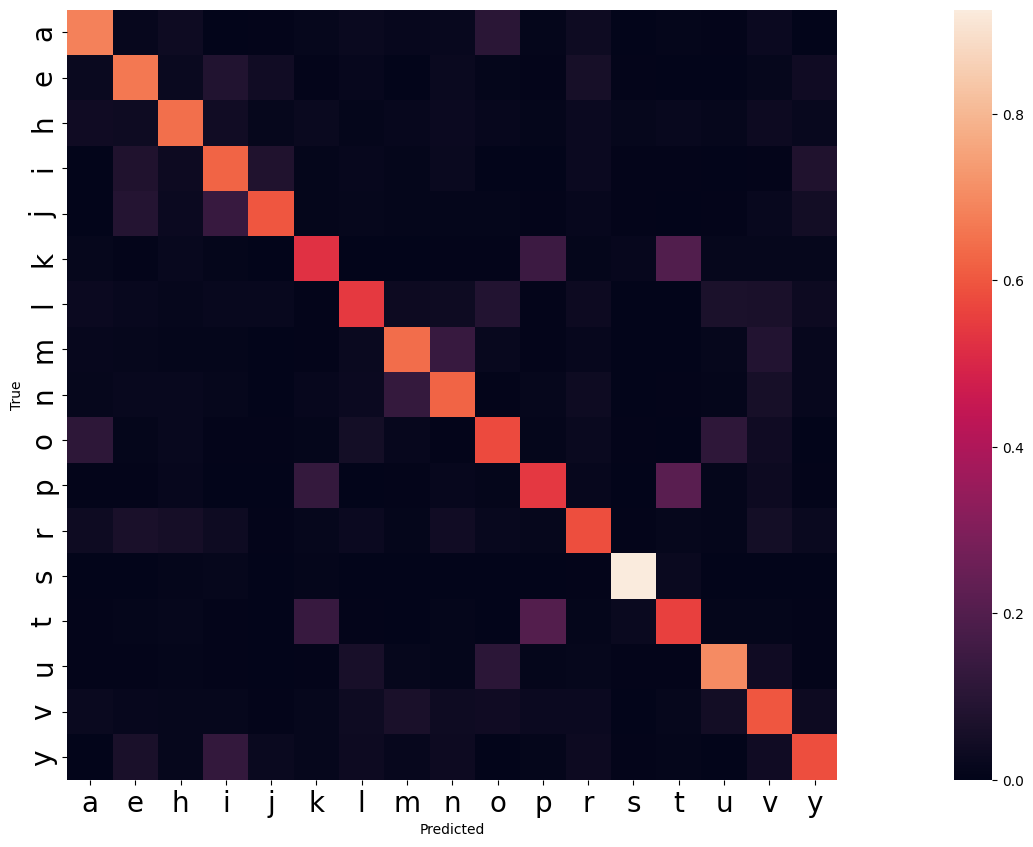

In [22]:
plot_confusion(C, phonemes)

<b>Answer the following questions:</b>

a. Based on the confusion matrix, what can you conclude about phoneme recognition as a task and recognition performance of different phoneme classifiers?

b. Give examples of difficulties this classifier has.

c. Include the (visualized) confusion matrix with the answer.

### Question 4:

Variables `tw1`, `tw2` and `tw3` contain the feature representations of three Finnish words. <b>Classify</b> their features using your best model. 

<b>Answer the following questions:</b>

a. Try to identify the words based on the classification result. (We believe this demonstration works especially well if you <i>don't</i> speak Finnish. Points are rewarded for attempts, not correct answers.)

b. What problems do you see in the frame based classification if one wants to recognize whole words?

c. Describe ideas to improve the results.

## Discriminative models

When we classified feature vectors above, we wanted to pick the most probable phoneme <i>y</i>, given a feature vector <i>x</i>. In other words, we wanted: arg max<sub>y</sub> p(y|x). However, GMMs are a generative model: they learn p(x|y) and p(y). With the Bayes rule, these can be used to find the most probable class by:
<br><br>
<center>arg max<sub>y</sub> p(y|x) = arg max<sub>y</sub> p(x|y)p(y)</center>

We can also construct a model for p(y|x) directly. This type of model is called a discriminative model. Say we want to classify animals as cats or dogs based their silhouettes.

The generative approach is to learn to draw dog silhouettes and cat silhouettes. Look at dogs, make notes about prominent features: four legs, a tail. Look at cats: four legs, a tail. To classify new silhouettes, estimate if you'd be more likely to draw something similar when drawing a cat or a dog.

The discriminative approach is to just look at a bunch of dog and cat pairs and figure out what the differences are. Big whiskers: it's a cat. Large animal: it's a dog. But ask the discriminative model how many legs a dog should have? No idea.

Whether the generative approach or the discriminative approach works better depends on the task. Empirically, in most speech recognition tasks the discriminative approach gives better results.

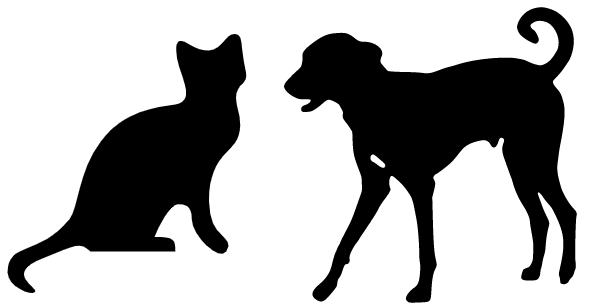

In [23]:
from IPython.display import Image
Image('images/silhouettes.png')

## Deep neural networks

There are many discriminative classifiers, like logistic regression or support vector machines. But Deep neural networks (DNN) classifiers have worked especially well. Since the beginning of the 2010-decade, most machine learning fields, like image classification and speech recognition, attain their state-of-the-art results by applying some type of DNN methods. Nowadays almost all speech recognition systems replace GMMs by DNNs (though GMMs are still used during the iterative process through which the most complex systems are built).

Although this course does not have time to go into the details of DNNs, it would seem strange not to mention them either, since they are now used everywhere. Aalto has a popular course, where you can learn more: [CS-E4890 Deep Learning](https://oodi.aalto.fi/a/opintjakstied.jsp?OpinKohd=1129662615).  For a clear introduction, see [this video series](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi).

A generative approach actually assumes a model of how the data is generated. Discriminatively trained DNNs learn distinguishing factors directly from the data. In fact they are especially good at this. Many aspects of MFCCs have been manually engineered to work with GMMs' assumptions; with DNNs some of the feature extraction steps can be skipped, and the classifier learns more powerful representations in a data-driven way.

Now we will try a Multi Layer Perceptron (MLP, a basic type of DNN) classifier for our phoneme recognition task.

In [24]:
from sklearn.neural_network import MLPClassifier

In [25]:
num_hidden_layers = 3
layer_size = 300
num_classes = len(np.unique(train_class))

In [26]:
neural_network = MLPClassifier(hidden_layer_sizes=(layer_size, layer_size),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.001,
                    alpha=1e-4,
                    max_iter=15,
                    random_state=0)

neural_network.fit(train_data_normalized, train_class)

c:\Users\springnuance\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(300, 300), max_iter=15, random_state=0)

In [27]:
predictions = neural_network.predict(test_data_normalized)

In [28]:
print(accuracy_score(predictions, test_class) * 100)

68.1466755025403


In [29]:
total_parameters = (26 * layer_size + layer_size * layer_size + layer_size * layer_size + layer_size * num_classes) + num_hidden_layers * layer_size + num_classes
print('The total number of parameters in the MLP model is: {0}'.format(total_parameters))

The total number of parameters in the MLP model is: 193817


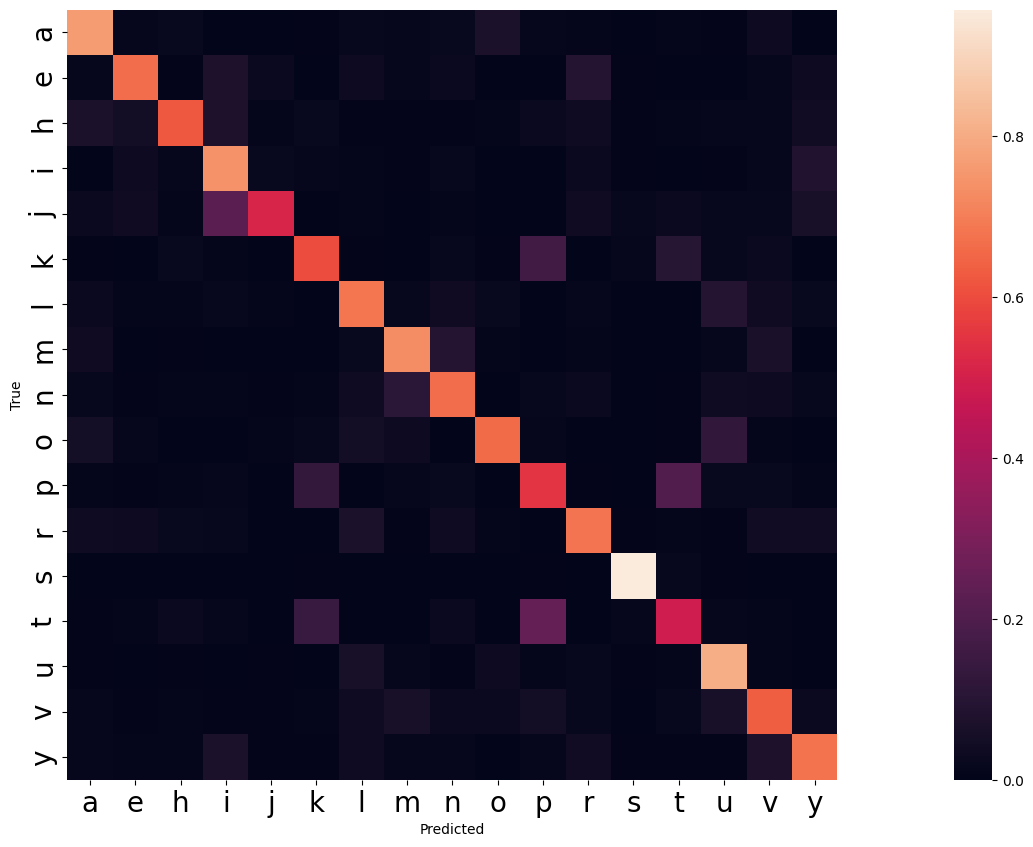

In [30]:
C = confusion_matrix(test_class, predictions)
plot_confusion(C, phonemes)

### Question 5:

DNNs can leverage large datasets, but here we have quite a small training set.

a. Which model performs classification better, the DNN or your best GMM?

b. The number of trained parameters in the DNN is reported above. Now look inside your best GMM model, the dictionary returned by `train_gmm`. Note: strictly speaking, there is a separate GMM for each class (phoneme), so count the total number of parameters for all the classes altogether. How many trained (estimated) parameters does your best GMM have (Remember: we used diagonal-covariance matrix GMMs)? Which model type used more parameters?

## Sampling

Since the GMM is a generative model, we can sample some MFCCs from it. Sample 100 MFCCs from each phoneme class by running:

In [31]:
def sample(gmm_models, sampled_class):
    sampled_data = []
    for cls in sampled_class:
        gmm_model = gmm_models[cls]
        sampled_data.append(gmm_model.sample(1)[0])
    return np.array(sampled_data).squeeze()

In [32]:
sampled_class = np.arange(0, 17, 1).repeat(100)
gmm_models = S['model']
sampled_data = sample(gmm_models, sampled_class)

Notice that sampled_class has the reference `class numbers`.

Now classify the sampled MFCCs with the GMM model, just like you did with `train_data` and `test_data`. Then classify them with the DNN.

In [33]:
# GMM predict
predictions = predict(sampled_data, S, n_components)
print(accuracy_score(predictions, sampled_class) * 100)

64.70588235294117


In [34]:
# DNN predict
sampled_data_normalized = z.transform(sampled_data)
predictions = neural_network.predict(sampled_data_normalized)
print(accuracy_score(predictions, sampled_class) * 100)

35.294117647058826


### Question 6:

a. Which model has lower classification error on the sampled MFCCs? Why might that be?